In [37]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import erf
import emcee
from scipy.optimize import root_scalar
import agama
import corner
import astropy.coordinates as coord
import astropy.units as u
import multiprocessing

In [31]:
x=5
y=1.493*x**0.354/(1+1.1756*x**0.752)
z=y*200
vmax_2 = 164.35**2*0.216*10.272/(np.log(1+10.272)-10.272/(1+10.272))
print(vmax_2**0.5)
print(x,y,z)

199.15284491037147
5 0.5338977832001691 106.77955664003382


In [36]:
(48.21*43018/16/2.16)**0.5

244.96656163534738

In [4]:
agama.setUnits(length=1, mass=1e10, velocity=1)

In [24]:
agama.setUnits(length=1, mass=1e10, velocity=1)
# 常数和参数（单位：kpc, Gyr, 10^10 Msun）
G = 43018  # 单位转换后：kpc³/(10¹⁰ Msun·Gyr²)
M_bulge = 1.0    # 10¹⁰ Msun (原1e10 Msun)
M_disk = 7     # 10¹⁰ Msun (原5e10 Msun)

a_disk = 3.     # kpc
a_halo = 27.1269  # kpc

b_disk = 0.167 * a_disk
a_bulge = 0.7 

M_halo = 5.56*(1+8.2/a_halo)**2/(8.2/a_halo)**2
print(M_halo)



para_halo = agama.Density(type='Dehnen', mass=M_halo, scaleRadius=a_halo, gamma = 1, axisRatioZ=1)
para_bulge = agama.Density(type='Dehnen', mass=M_bulge, scaleRadius=a_bulge, gamma = 1)
para_disk = agama.Density(type='Disk', mass=M_disk, scaleRadius=a_disk, scaleHeight=b_disk,sersicIndex=1)
# potential
pot_mul = agama.Potential(type='Multipole',density=para_bulge+para_halo,
                                    lmax=12, gridSizeR=1000, rmin=1e-1, rmax=300)
MWpot = agama.Potential(pot_mul)
df_halo = agama.DistributionFunction(type='QuasiSpherical',potential=MWpot, density=para_halo)


grid_r  = np.linspace(0.1, 300, 2000)  # 0.1 kpc to 100 kpc
grid_sig= agama.GalaxyModel(MWpot, df_halo).moments(
    np.column_stack((grid_r, grid_r*0, grid_r*0)), dens=False, vel=False, vel2=True)[:,0]**0.5
spl  = agama.Spline(grid_r, grid_sig)  # spline
sigma   = lambda r: spl(r)


103.19487866852467


In [33]:
print(para_halo.enclosedMass(2.16*a_halo))

48.21603368008619


In [29]:
rlmc_200 = (43018*M_halo)**(1/3) 
print(rlmc_200)
rlmc_scal = 16
c_LMC = rlmc_200/rlmc_scal
a_LMC = rlmc_scal*np.sqrt(2*(np.log(1+c_LMC)-c_LMC/(1+c_LMC)))
print(a_LMC,c_LMC)

164.3499034672362
27.81448561560923 10.271868966702263


In [32]:
sigma(80)

89.3310431531769

In [11]:
def Potential(M_halo, M_LMC, q_MW):
    rlmc_200 = (43018*M_LMC)**(1/3) 
    rlmc_scal = 8.5*(M_LMC/10)**0.6
    c_LMC = rlmc_200/rlmc_scal
    a_LMC = rlmc_scal*np.sqrt(2*(np.log(1+c_LMC)-c_LMC/(1+c_LMC)))
    
    para_halo = agama.Density(type='Dehnen', mass=M_halo, scaleRadius=a_halo, gamma = 1, axisRatioZ=q_MW)
    para_bulge = agama.Density(type='Dehnen', mass=M_bulge, scaleRadius=a_bulge, gamma = 1)
    para_disk = agama.Density(type='Disk', mass=M_disk, scaleRadius=a_disk, scaleHeight=b_disk,sersicIndex=1)
    # potential
    pot_mul = agama.Potential(type='Multipole',density=para_bulge+para_halo,
                                        lmax=12, gridSizeR=1000, rmin=1e-1, rmax=300)
    pot_cyl = agama.Potential(type='CylSpline',density=para_disk,
                                        gridSizeR=50, gridSizez=30, Rmin=0.1, Rmax=50, zmin=0.001, zmax=20, mmax=8)
    MWpot = agama.Potential(pot_cyl, pot_mul)
    LMCpot = agama.Potential(type='Dehnen', mass=M_LMC, scaleRadius=a_LMC, gamma = 1)
    return MWpot, LMCpot, a_LMC


def rotation_matrix_x(theta):
    """
    绕 x 轴旋转的旋转矩阵 (角度 theta)
    参数:
        theta: 绕 x 轴旋转的角度 (弧度)
    返回:
        3x3 旋转矩阵
    """
    return np.array([
        [1, 0, 0],
        [0, np.cos(theta), -np.sin(theta)],
        [0, np.sin(theta), np.cos(theta)]
    ])
    
def rotation_matrix_y(phi):
    """
    绕 y 轴旋转的旋转矩阵 (角度 phi)
    参数:
        phi: 绕 y 轴旋转的角度 (弧度)
    返回:
        3x3 旋转矩阵
    """
    return np.array([
        [np.cos(phi), 0, np.sin(phi)],
        [0, 1, 0],
        [-np.sin(phi), 0, np.cos(phi)]
    ])

def rotation_matrix_z(phi):
    """
    绕 z 轴旋转的旋转矩阵 (角度 phi)
    参数:
        phi: 绕 z 轴旋转的角度 (弧度)
    返回:
        3x3 旋转矩阵
    """
    return np.array([
        [np.cos(phi), -np.sin(phi), 0],
        [np.sin(phi), np.cos(phi), 0],
        [0, 0, 1]
    ])

#坐标系转换
def Galactic_to_icrs(pos,vel):
    gc = coord.SkyCoord(x= pos[0]* u.kpc, y=pos[1]* u.kpc,
            z= pos[2]* u.kpc,
            v_x= vel[0]* u.km / u.s,
            v_y= vel[1]* u.km / u.s,
            v_z= vel[2]* u.km / u.s, frame='galactocentric',
            representation_type='cartesian', differential_type='cartesian',
            galcen_distance=8.122* u.kpc, z_sun=20.8 * u.pc,
            galcen_v_sun=coord.CartesianDifferential(
                 [12.9, 245.6, 7.8] * u.km / u.s))
    c = gc.transform_to(coord.ICRS)
    ra = np.array(c.ra)
    dec = np.array(c.dec)
    distance = np.array(c.distance)
    pmra = np.array(c.pm_ra_cosdec)
    pmdec = np.array(c.pm_dec)
    vr = np.array(c.radial_velocity)
    return ra, dec, distance, pmra, pmdec, vr


def equation(t, y,MWpot, LMCpot, a_LMC):
    r_LMC = y[0:3]
    v_LMC = y[3:6]
    v_norm = np.linalg.norm(v_LMC)  # 避免除零
    r_norm = np.linalg.norm(r_LMC)  # 避免除零

    ln_Lambda = 1/2 * np.log(1 + (r_norm / a_LMC / 3)**2)  # 度量参数
    rho_halo = MWpot.density(r_LMC)  # 银河系的密度
    X_c = v_norm / (2**0.5 * 120)  # 假设速度分散为 200 km/s
    erf_term = erf(X_c) - 2 * X_c / np.sqrt(np.pi) * np.exp(-X_c**2)

    # 动力摩擦力
    a_df = 4 * np.pi * G**2 * M_LMC * rho_halo * ln_Lambda * erf_term * v_LMC / v_norm**3

    
    
    
    # LMC的加速度
    acc_LMC = MWpot.force(r_LMC) + a_df + LMCpot.force(r_LMC)

    return np.concatenate((v_LMC, acc_LMC))


# 初始条件（kpc, km/s需转换）
y0 = np.zeros(6)
y0[0:3] = [-0.6143609652013762,-41.02036741646231, -26.832974651917674]# [500,0,0] #LMC初始位置
y0[3:6] = [69.81047009397867, 221.9356211949808, -214.01029566668603]# [0,40,0]#     # LMC初始速度

# 时间范围（Gyr）
t_span = (0, 10)  # 积分10 Gyr

M_MW = 92.6 # 10^10 Msun
M_LMC = 14 # 10^10 Msun
q_MW = 1 # 银河系的扁率
MWpot, LMCpot, a_LMC = Potential(M_MW, M_LMC, q_MW)  # 固定参数



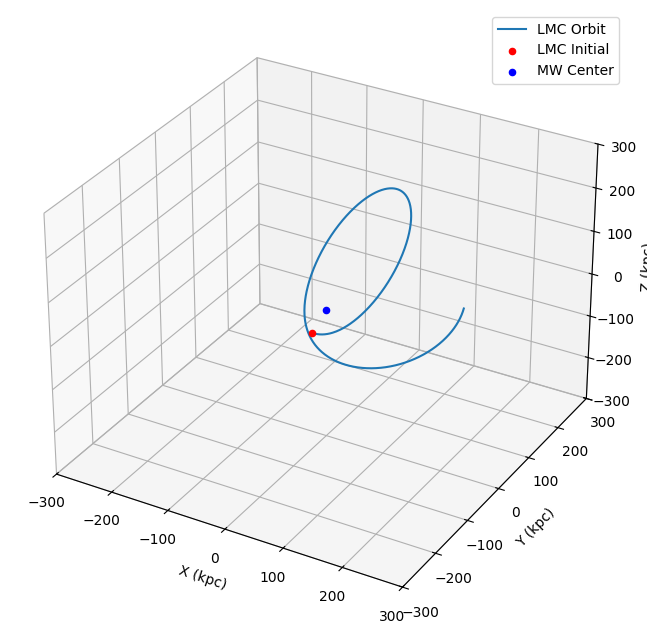

In [12]:
# 使用新的方程求解 ODE
sol = solve_ivp(equation, t_span, y0, method='RK45', args=(MWpot, LMCpot, a_LMC),
                rtol=1e-6, t_eval=np.linspace(t_span[0], t_span[1], 1000))

t = sol.t
x_LMC, y_LMC, z_LMC = sol.y[0], sol.y[1], sol.y[2]
vx_LMC, vy_LMC, vz_LMC = sol.y[3], sol.y[4], sol.y[5]



# 三维轨迹可视化
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_LMC, y_LMC, z_LMC, label='LMC Orbit')

ax.scatter(x_LMC[0], y_LMC[0], z_LMC[0], c='r', marker='o', label='LMC Initial')
ax.scatter(0, 0, 0, c='b', marker='o', label='MW Center')
ax.set_xlabel('X (kpc)')
ax.set_ylabel('Y (kpc)')
ax.set_zlabel('Z (kpc)')
ax.set_xlim(-300, 300)
ax.set_ylim(-300, 300)
ax.set_zlim(-300, 300)
plt.legend()
plt.show()

t=3 Gyr时的LMC位置: (9.24, 231.74, 120.99) kpc
t=3 Gyr时的LMC速度: (-13.20, -21.72, 55.30) km/s


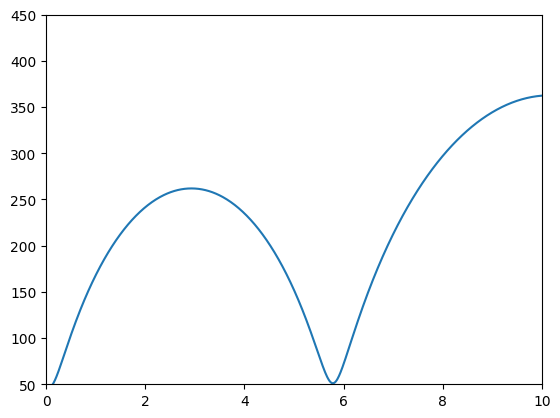

In [14]:

rlmc_mw = np.sqrt((x_LMC)**2 + (y_LMC )**2 + (z_LMC)**2)
plt.plot(t, rlmc_mw)
plt.xlim(0, 10)
plt.ylim(50, 450)
#t=3时候的速度位置
t_index = np.argmin(np.abs(t - 2.8))
x_LMC_3 = x_LMC[t_index]
y_LMC_3 = y_LMC[t_index]
z_LMC_3 = z_LMC[t_index]
vx_LMC_3 = vx_LMC[t_index]
vy_LMC_3 = vy_LMC[t_index]
vz_LMC_3 = vz_LMC[t_index]
print(f"t=3 Gyr时的LMC位置: ({x_LMC_3:.2f}, {y_LMC_3:.2f}, {z_LMC_3:.2f}) kpc")
print(f"t=3 Gyr时的LMC速度: ({vx_LMC_3:.2f}, {vy_LMC_3:.2f}, {vz_LMC_3:.2f}) km/s")

In [ ]:
t=3 Gyr时的LMC位置: (42.16, -30.57, -250.20) kpc
t=3 Gyr时的LMC速度: (-9.30, -60.75, 5.60) km/s

t=3 Gyr时的LMC位置: (10.41, 238.64, 119.75) kpc
t=3 Gyr时的LMC速度: (-12.72, -16.76, 56.32) km/s


SyntaxError: invalid syntax (2473096852.py, line 1)